In [33]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from scipy.stats import boxcox

In [97]:
data_dict = pd.read_csv(r'C:\Users\Lucas\Documents\NOVA IMS\Machine Learning\Final Project\Nata_Files\data_dictionary.csv')
pastel_d_nata_lrn = pd.read_csv(r'C:\Users\Lucas\Documents\NOVA IMS\Machine Learning\Final Project\Nata_Files\learn.csv', index_col=0)
pastel_d_nata_pred = pd.read_csv(r'C:\Users\Lucas\Documents\NOVA IMS\Machine Learning\Final Project\Nata_Files\predict.csv', index_col=0)
pastel_d_nata_sampred = pd.read_csv(r'C:\Users\Lucas\Documents\NOVA IMS\Machine Learning\Final Project\Nata_Files\sampred.csv', index_col=0)

Based on the insights gained from the exploration we concluded that the data was often skewed and had many outliers, to mitigate this issue we will be taking a greater look at the different features and see whether we can get rid of some of the outliers and fill some missing values

In [98]:
pastel_d_nata_lrn = pastel_d_nata_lrn[pastel_d_nata_lrn['quality_class'].isna()==False]

In [99]:
def origin_replace(df):
    origin_update = []
    for city in df['origin']:
        if 'lisboa' in str(city).lower() or 'lisbon' in str(city).lower():
            city= 0
            origin_update.append(city)
        elif 'porto' in str(city).lower():
            city= 1
            origin_update.append(city)
        else:
            origin_update.append(city)
    df.loc[:,'origin'] = pd.Series(origin_update, index=df.index)
    return df

In [100]:
pastel_d_nata_lrn = origin_replace(pastel_d_nata_lrn)

The prediction dataset is cleaned to be uniform with the learning dataset

In [101]:
pastel_d_nata_pred = origin_replace(pastel_d_nata_pred)

In [103]:
prepped_pred = pastel_d_nata_pred.drop(['notes_baker', 'pastry_type'], axis=1)

Idk something

In [39]:
X=pastel_d_nata_lrn.drop('quality_class',axis=1)
y=pastel_d_nata_lrn[['quality_class']]

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75,stratify=y, random_state = 15)

In [41]:
pastel_d_nata_lrn.sort_values('egg_temperature', ascending=False)[['egg_temperature','quality_class']]
#capping at 240

,egg_temperature,quality_class
id,,
1272,575.0,KO
5025,304.0,KO
3142,287.0,KO
3129,270.0,KO
5026,260.0,KO
...,...,...
3995,NaN,OK
4188,NaN,OK
4732,NaN,OK


In [42]:
pastel_d_nata_lrn.sort_values('salt_ratio', ascending=False)[['salt_ratio','quality_class']].head(15)
#capping at 420

,salt_ratio,quality_class
id,,
2695,640.32,KO
651,636.67,KO
2525,472.03,KO
3223,431.76,KO
2897,419.47,OK
4221,414.71,KO
3344,410.58,OK
2894,407.05,KO
43,402.47,KO


In [43]:
pastel_d_nata_lrn.sort_values('vanilla_extract', ascending=False)[['vanilla_extract','quality_class']].head(5)

,vanilla_extract,quality_class
id,,
4327,20.8,OK
2695,20.1,KO
2386,15.7,KO
4515,15.6,KO
2849,15.5,OK


Considering that the top 10 longest baking durations all fail the quality check we thought it best to cut those in order to normalize the distribution

In [44]:
pastel_d_nata_lrn.sort_values('baking_duration', ascending=False)[['baking_duration','quality_class']].head(12)
#capping at 63

,baking_duration,quality_class
id,,
2227,89.0,KO
975,79.0,KO
1843,77.0,KO
331,73.0,KO
4776,71.0,KO
4752,69.0,KO
4728,67.0,KO
2607,65.0,KO
1614,63.0,KO


In [45]:
#cutting the extreme values in order to mitigate outliers
X_train_cap= X_train[(X_train.egg_temperature<240)|(X_train.egg_temperature.isna())]
X_train_cap= X_train[(X_train.salt_ratio<420)|(X_train.salt_ratio.isna())]
X_train_cap= X_train[(X_train.baking_duration<63)|(X_train.baking_duration.isna())]
#X_train= X_train[X_train.vanila_extract>=16]

In [46]:
X_train_cap.isna().sum()

ambient_humidity       15
baking_duration         0
cooling_period          0
cream_fat_content      18
egg_temperature        19
egg_yolk_count         19
final_temperature      16
lemon_zest_ph          22
notes_baker          3890
origin                125
oven_temperature       17
pastry_type          1363
preheating_time        10
salt_ratio              9
sugar_content          10
vanilla_extract        13
dtype: int64

In [47]:
#checking whether there is significant overlap in missing values

In [48]:
pdn_less_features = pastel_d_nata_lrn.drop(['notes_baker','pastry_type','origin','quality_class'],axis=1)
pdn_mvals=pdn_less_features[pdn_less_features.isnull().any(axis=1)]
pdn_mvals

,ambient_humidity,baking_duration,cooling_period,cream_fat_content,egg_temperature,egg_yolk_count,final_temperature,lemon_zest_ph,oven_temperature,preheating_time,salt_ratio,sugar_content,vanilla_extract
id,,,,,,,,,,,,,
1,54.0,24.0,26.0,100.4,52.0,11.0,309.0,3.2,NaN,207.0,42.74,22.8,5.7
11,73.0,23.0,27.0,98.8,84.0,9.0,NaN,3.1,226.0,223.0,58.94,25.8,3.5
14,66.0,29.0,17.0,95.6,126.0,9.0,NaN,3.1,326.0,199.0,34.69,131.4,5.0
69,78.0,38.0,35.0,98.9,41.0,9.0,201.0,NaN,220.0,260.0,93.61,30.9,5.9
75,63.0,23.0,24.0,99.1,NaN,11.0,245.0,3.2,251.0,210.0,23.49,53.0,6.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5037,76.0,26.0,40.0,100.9,42.0,9.0,152.0,NaN,150.0,274.0,84.83,25.8,5.0
5101,48.0,23.0,37.0,104.9,128.0,9.0,366.0,3.2,374.0,186.0,44.09,79.6,NaN
5137,61.0,20.0,27.0,95.3,82.0,11.0,237.0,3.4,234.0,225.0,40.61,NaN,4.4


first we have to scale the data based on each of the distributions.

In [49]:
#prepping pastel_d_nata_pred by removing non-numerical values and scaling according to X_train_cap
pastel_d_nata_pred

,ambient_humidity,baking_duration,cooling_period,cream_fat_content,egg_temperature,egg_yolk_count,final_temperature,lemon_zest_ph,notes_baker,origin,oven_temperature,pastry_type,preheating_time,salt_ratio,sugar_content,vanilla_extract
id,,,,,,,,,,,,,,,,
5201,79.0,22,40,98.6,79.0,9.0,259.0,3.2,NaN,NaN,268.0,NaN,208.0,49.63,182.6,4.0
5202,49.0,26,32,101.9,105.0,9.0,287.0,3.2,NaN,NaN,287.0,Pastel de nata,189.0,182.54,76.2,4.8
5203,80.0,28,24,96.6,20.0,10.0,64.0,3.4,NaN,NaN,74.0,Pastel Nata,201.0,100.41,23.5,6.1
5204,74.0,21,37,97.2,81.0,9.0,314.0,3.0,NaN,NaN,317.0,NaN,220.0,46.66,143.2,4.9
5205,41.0,19,41,97.3,104.0,10.0,246.0,3.2,NaN,NaN,243.0,Pastel Nata,191.0,39.45,143.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6496,73.0,24,23,98.9,58.0,10.0,208.0,3.1,NaN,NaN,200.0,Pastel De Nata,189.0,37.80,142.6,4.0
6497,66.0,21,34,100.6,62.0,10.0,277.0,3.1,NaN,NaN,264.0,Pastel de nata,235.0,33.78,102.2,4.8
6498,41.0,49,23,98.9,20.0,11.0,57.0,3.4,NaN,NaN,69.0,Pastel de nata,243.0,86.73,21.3,7.4


In [104]:
#splitting the data in different types of scaling:
z_scaler = StandardScaler()
r_scaler = RobustScaler()
p_scaler = PowerTransformer()
m_scaler = MinMaxScaler()
#scaling ambient_humidity
X_train_scaled = pd.DataFrame(m_scaler.fit_transform(X_train_cap[['ambient_humidity']]), columns=['ambient_humidity'], index=X_train_cap.index)
X_val_scaled = pd.DataFrame(m_scaler.transform(X_val[['ambient_humidity']]), columns=['ambient_humidity'], index=X_val.index)
scaled_pred = pd.DataFrame(m_scaler.transform(prepped_pred[['ambient_humidity']]), columns=['ambient_humidity'], index=prepped_pred.index)
#scaling baking_duration
X_train_scaled['baking_duration'] = p_scaler.fit_transform(X_train_cap[['baking_duration']])
X_val_scaled['baking_duration'] = p_scaler.transform(X_val[['baking_duration']])
scaled_pred['baking_duration'] = p_scaler.transform(prepped_pred[['baking_duration']])
#scaling cooling_period
X_train_scaled['cooling_period'] = r_scaler.fit_transform(X_train_cap[['cooling_period']])
X_val_scaled['cooling_period'] = r_scaler.transform(X_val[['cooling_period']])
scaled_pred['cooling_period'] = r_scaler.transform(prepped_pred[['cooling_period']])
#scaling cream_fat_content
X_train_scaled['cream_fat_content'] = z_scaler.fit_transform(X_train_cap[['cream_fat_content']])
X_val_scaled['cream_fat_content'] = z_scaler.transform(X_val[['cream_fat_content']])
scaled_pred['cream_fat_content'] = z_scaler.transform(prepped_pred[['cream_fat_content']])
#scaling egg_temperature
egg_transform = pd.DataFrame(boxcox(X_train_cap.egg_temperature, lmbda=-0.2))
egg_transform_val = pd.DataFrame(boxcox(X_val.egg_temperature, lmbda=-0.2))
egg_transform_pred = pd.DataFrame(boxcox(prepped_pred.egg_temperature, lmbda=-0.2))
X_train_scaled['egg_temp'] = r_scaler.fit_transform(egg_transform)
X_val_scaled['egg_temp'] = r_scaler.transform(egg_transform_val)
scaled_pred['egg_temp'] = r_scaler.transform(egg_transform_pred)
#scaling egg_yolk_content
X_train_scaled['egg_yolk_cnt'] = m_scaler.fit_transform(X_train_cap[['egg_yolk_count']])
X_val_scaled['egg_yolk_cnt'] = m_scaler.transform(X_val[['egg_yolk_count']])
scaled_pred['egg_yolk_cnt'] = m_scaler.transform(prepped_pred[['egg_yolk_count']])
#scaling final_temperature
X_train_scaled['final_temp'] = r_scaler.fit_transform(X_train_cap[['final_temperature']])
X_val_scaled['final_temp'] = r_scaler.transform(X_val[['final_temperature']])
scaled_pred['final_temp'] = r_scaler.transform(prepped_pred[['final_temperature']])
#scaling lemon_zest_ph
X_train_scaled['lemon_zest_ph'] = z_scaler.fit_transform(X_train_cap[['lemon_zest_ph']])
X_val_scaled['lemon_zest_ph'] = z_scaler.transform(X_val[['lemon_zest_ph']])
scaled_pred['lemon_zest_ph'] = z_scaler.transform(prepped_pred[['lemon_zest_ph']])
#scaling oven_temperature
X_train_scaled['oven_temp'] = r_scaler.fit_transform(X_train_cap[['oven_temperature']])
X_val_scaled['oven_temp'] = r_scaler.transform(X_val[['oven_temperature']])
scaled_pred['oven_temp'] = r_scaler.transform(prepped_pred[['oven_temperature']])
#scaling preheating_time
preheat_transform = pd.DataFrame(boxcox(X_train_cap.preheating_time, lmbda=-0.2))
preheat_transform_val = pd.DataFrame(boxcox(X_val.preheating_time, lmbda=-0.2))
preheat_transform_pred = pd.DataFrame(boxcox(prepped_pred.preheating_time, lmbda=-0.2))
X_train_scaled['preheat_time'] = z_scaler.fit_transform(preheat_transform)
X_val_scaled['preheat_time'] = z_scaler.transform(preheat_transform_val)
scaled_pred['preheat_time'] = z_scaler.transform(preheat_transform_pred)
#scaling salt_ratio
salt_transform = pd.DataFrame(boxcox(X_train_cap.salt_ratio, lmbda=-0.3))
salt_transform_val = pd.DataFrame(boxcox(X_val.salt_ratio, lmbda=-0.3))
salt_transform_pred = pd.DataFrame(boxcox(prepped_pred.salt_ratio, lmbda=-0.3))
X_train_scaled['salt_ratio'] = z_scaler.fit_transform(salt_transform)
X_val_scaled['salt_ratio'] = z_scaler.transform(salt_transform_val)
scaled_pred['salt_ratio'] = z_scaler.transform(salt_transform_pred)
#scaling_sugar_content
X_train_scaled['sugar_content'] = r_scaler.fit_transform(X_train_cap[['sugar_content']])
X_val_scaled['sugar_content'] = r_scaler.transform(X_val[['sugar_content']])
scaled_pred['sugar_content'] = r_scaler.transform(prepped_pred[['sugar_content']])
#scaling vanilla_extract
X_train_scaled['vanilla_extract'] = p_scaler.fit_transform(X_train_cap[['vanilla_extract']])
X_val_scaled['vanilla_extract'] = p_scaler.transform(X_val[['vanilla_extract']])
scaled_pred['vanilla_extract'] = p_scaler.transform(prepped_pred[['vanilla_extract']])
#joining binary origin to the new dataframe
X_train_scaled = X_train_scaled.join(pd.Series(X_train_cap.origin, name='origin_dummy'))
X_val_scaled = X_val_scaled.join(pd.Series(X_val.origin, name='origin_dummy'))
scaled_pred = scaled_pred.join(pd.Series(prepped_pred.origin, name='origin_dummy'))

In [ ]:
#AI solution - won't implement until fully understood
def custom_scale_sets(X_train_cap, X_val, prepped_pred, feature_config):
    X_train_scaled = pd.DataFrame(index=X_train_cap.index)
    X_val_scaled = pd.DataFrame(index=X_val.index)
    scaled_pred = pd.DataFrame(index=prepped_pred.index)

    scalers = {}

    for feature, (scaler_type, boxcox_lambda) in feature_config.items():
        base_scaler = None
        if scaler_type == "minmax":
            base_scaler = MinMaxScaler()
        elif scaler_type == "standard":
            base_scaler = StandardScaler()
        elif scaler_type == "robust":
            base_scaler = RobustScaler()
        elif scaler_type == "power":
            base_scaler = PowerTransformer()
        else:
            continue

        # Apply boxcox if lambda exists
        if boxcox_lambda is not None:
            train_trans = pd.DataFrame(boxcox(X_train_cap[feature], lmbda=boxcox_lambda))
            val_trans = pd.DataFrame(boxcox(X_val[feature], lmbda=boxcox_lambda))
            pred_trans = pd.DataFrame(boxcox(prepped_pred[feature], lmbda=boxcox_lambda))
        else:
            train_trans = X_train_cap[[feature]]
            val_trans = X_val[[feature]]
            pred_trans = prepped_pred[[feature]]

        # Fit on train, transform all sets
        scalers[feature] = base_scaler.fit(train_trans)
        X_train_scaled[feature] = scalers[feature].transform(train_trans)
        X_val_scaled[feature] = scalers[feature].transform(val_trans)
        scaled_pred[feature] = scalers[feature].transform(pred_trans)

    # Add categorical/dummy columns
    for df_scaled, df_raw in zip([X_train_scaled, X_val_scaled, scaled_pred], [X_train_cap, X_val, prepped_pred]):
        df_scaled['origin_dummy'] = df_raw['origin']

    return X_train_scaled, X_val_scaled, scaled_pred

# Example feature config (column: (scaler_type, boxcox_lambda))
feature_config = {
    'ambient_humidity': ('minmax', None),
    'baking_duration': ('power', None),
    'cooling_period': ('robust', None),
    'cream_fat_content': ('standard', None),
    'egg_temperature': ('robust', -0.2),
    'egg_yolk_count': ('minmax', None),
    'final_temperature': ('robust', None),
    'lemon_zest_ph': ('standard', None),
    'oven_temperature': ('robust', None),
    'preheating_time': ('standard', -0.2),
    'salt_ratio': ('standard', -0.3),
    'sugar_content': ('robust', None),
    'vanilla_extract': ('power', None)
}

X_train_scaled, X_val_scaled, scaled_pred = custom_scale_sets(X_train_cap, X_val, prepped_pred, feature_config)


In [51]:
X_train_scaled.head()

,ambient_humidity,baking_duration,cooling_period,cream_fat_content,egg_temp,egg_yolk_cnt,final_temp,lemon_zest_ph,oven_temp,preheat_time,salt_ratio,sugar_content,vanilla_extract,origin_dummy
id,,,,,,,,,,,,,,
4095,0.125,0.011091,-1.000000,-0.257456,0.708026,0.142857,0.974359,-0.106235,0.956140,-0.721211,0.099174,0.677329,-0.197245,1.0
4815,0.825,-0.336149,1.400000,0.043531,0.386808,0.714286,-0.247863,-0.106235,-0.210526,-0.622256,-2.300924,-0.183127,-1.958405,1.0
4737,0.475,1.445805,-1.133333,-0.207291,0.226707,0.714286,0.794872,1.706633,0.614035,-2.573081,-0.960830,0.832467,-0.114501,0.0
2951,0.875,-0.336149,0.000000,-0.006633,0.918771,0.285714,1.153846,-0.710524,1.052632,0.771831,-0.599712,0.766893,-0.197245,1.0
3410,0.075,-1.247236,-0.066667,1.849454,0.918771,0.428571,0.273504,0.498054,0.289474,-0.754616,-1.135179,0.266293,-1.421575,0.0


In [52]:
X_train_imp = KNNImputer(n_neighbors=3).fit_transform(X_train_scaled)
X_train_imp = pd.DataFrame(X_train_imp, columns=X_train_scaled.columns, index=X_train_scaled.index)

In [53]:
#pastel_d_nata_lrn.drop(['ambient_humidity','notes_baker','pastry_type', 'final_temperature', 'egg_temperature'], axis=1)

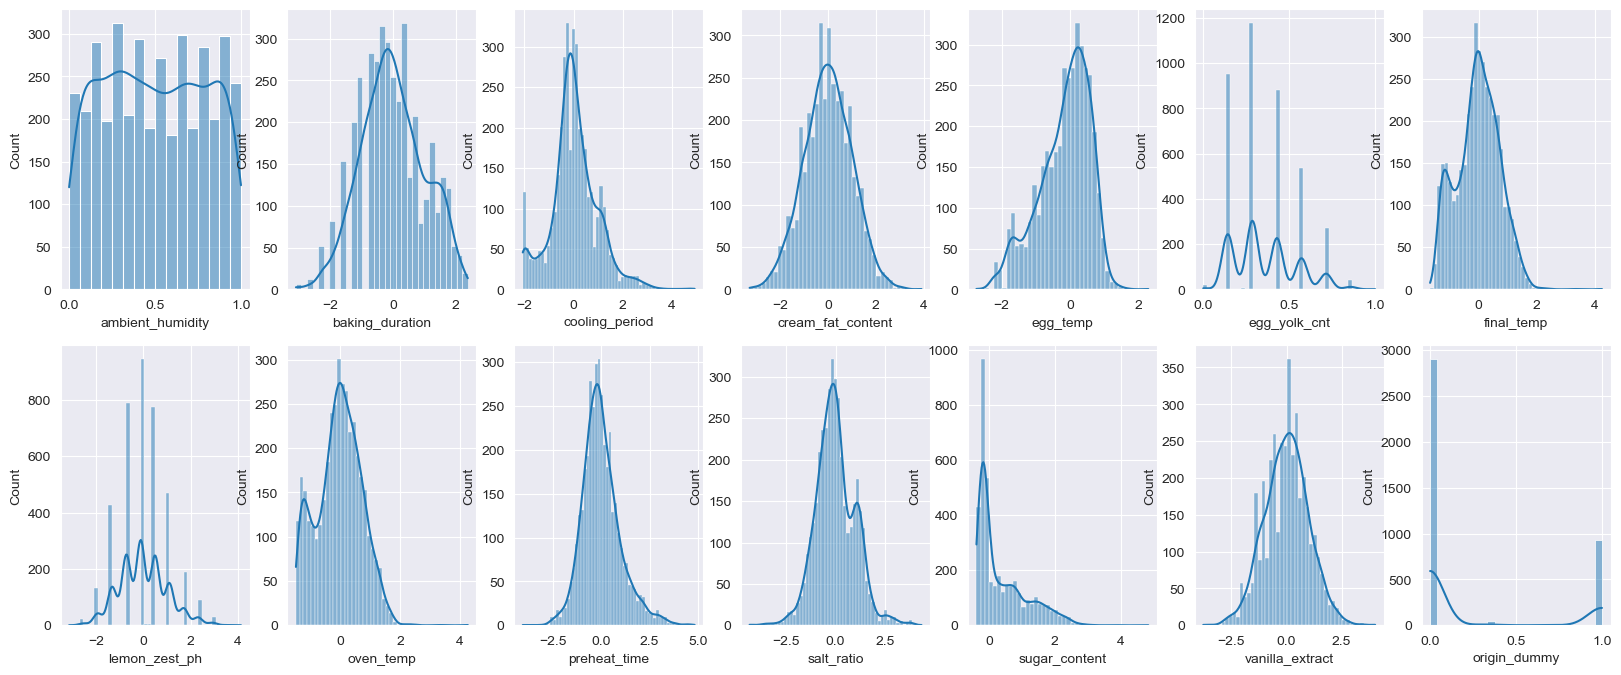

In [54]:
fig, axes = plt.subplots(2, 7, figsize=(20, 8))
axes = axes.flatten()

for nr, col in enumerate(X_train_imp.columns):
    sns.histplot(X_train_imp[col].dropna(), ax=axes[nr], kde=True)

plt.show()

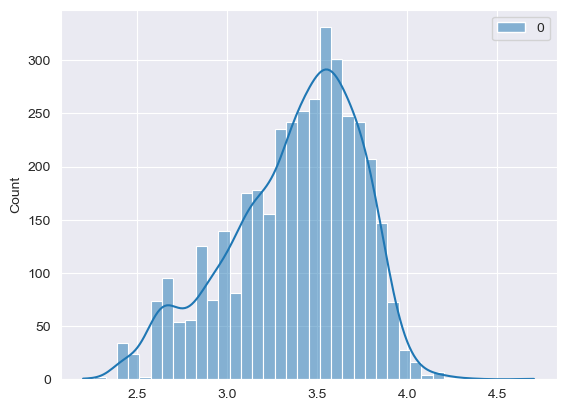

In [55]:
egg_transform = pd.DataFrame(boxcox(X_train_cap.egg_temperature, lmbda=-0.1))
sns.histplot(egg_transform, kde=True)
plt.show()

In [56]:
X_train_with_targets = X_train_imp
X_train_with_targets['target']=y_train
X_train_with_targets.to_csv(r'C:\Users\Lucas\Documents\NOVA IMS\Machine Learning\Final Project\Nata_Files\processed\train_dataset.csv')

X_val_with_targets = X_val_scaled
X_val_with_targets['target'] = y_val
X_val_with_targets.to_csv(r'C:\Users\Lucas\Documents\NOVA IMS\Machine Learning\Final Project\Nata_Files\processed\test_dataset.csv')